<a href="https://colab.research.google.com/github/curiosity806/2020_dacon_satellite_precipitation/blob/bogyung/Dacon_satellite_new_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
import gc
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score

warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 데이터 받아오기

In [0]:
submission = pd.read_csv('/content/drive/My Drive/2020 Kaggle Study/data/sample_submission.csv')
train = np.load('/content/drive/My Drive/2020 Kaggle Study/data/train_total_32bits.npy')
test = np.load('/content/drive/My Drive/2020 Kaggle Study/data/test.npy').astype('float32')
gmi_preci = np.load('/content/drive/My Drive/2020 Kaggle Study/data/gmi_preci_32bits.npy')

In [0]:
land_type_data = train[:,:,:,9]
land_type_data = np.where(land_type_data//100 == 2, 0.8,
                          np.where(land_type_data//100 == 3, 0.1,
                                   land_type_data//100))

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.reshape(-1, 15))
train_scaled = train_scaled.reshape(train.shape)
train_scaled[:,:,:,9] = land_type_data
train_scaled[:,:,:,-1] = gmi_preci.reshape(-1, 40, 40)  # GMI precipatation

train = train_scaled.copy()
del train_scaled

In [0]:
# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

## 모델만들기

In [0]:
def create_model():
    inputs=Input((40, 40, 10))
    
    bn=BatchNormalization()(inputs)
    conv0=Conv2D(256, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    bn=BatchNormalization()(conv0)
    conv=Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    concat=concatenate([conv0, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    conv=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
    concat=concatenate([concat, conv], axis=3)
        
    for i in range(5):
        bn=BatchNormalization()(concat)
        conv=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
        concat=concatenate([concat, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    outputs=Conv2D(1, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    model=Model(inputs=inputs, outputs=outputs)
    
    return model

In [0]:
model = create_model()

In [0]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

In [0]:
model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])

## 훈련

In [10]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle = True)
model_history = []
fold_number = 0

for train_index, test_index in kf.split(train):
    print(f'\nFold {fold_number}')
    fold_number = fold_number + 1
    
    def trainGenerator():
        for file in train[train_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:10]
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)
    train_dataset = tf.data.Dataset.from_generator(trainGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,10]),
                                                    tf.TensorShape([40,40,1])))
    train_dataset = train_dataset.batch(32).prefetch(1) # batch size: 512 -> 32

    def testGenerator():
        for file in train[test_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:10]
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)
    test_dataset = tf.data.Dataset.from_generator(testGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,10]),
                                                    tf.TensorShape([40,40,1])))
    test_size = len(test_index)
    test_dataset = test_dataset.batch(32).prefetch(1) # batch size: test_size -> 32

    history = model.fit(train_dataset, epochs = 10, verbose=1, validation_data = test_dataset)

    model_history.append(history)
    #del data
    del train_dataset
    del test_dataset
    gc.collect()


Fold 0
Epoch 1/10
1228/1228 [==============================] - 369s 300ms/step - loss: 0.1587 - maeOverFscore_keras: 1.7972 - fscore_keras: 0.6553 - val_loss: 0.1418 - val_maeOverFscore_keras: 1.6606 - val_fscore_keras: 0.6542
Epoch 2/10
1228/1228 [==============================] - 365s 298ms/step - loss: 0.1451 - maeOverFscore_keras: 1.5932 - fscore_keras: 0.6815 - val_loss: 0.1366 - val_maeOverFscore_keras: 1.5030 - val_fscore_keras: 0.6914
Epoch 3/10
1228/1228 [==============================] - 365s 297ms/step - loss: 0.1413 - maeOverFscore_keras: 1.5220 - fscore_keras: 0.6943 - val_loss: 0.1382 - val_maeOverFscore_keras: 1.4111 - val_fscore_keras: 0.7209
Epoch 4/10
1228/1228 [==============================] - 364s 297ms/step - loss: 0.1391 - maeOverFscore_keras: 1.4748 - fscore_keras: 0.7041 - val_loss: 0.1407 - val_maeOverFscore_keras: 1.4031 - val_fscore_keras: 0.7266
Epoch 5/10
1228/1228 [==============================] - 365s 297ms/step - loss: 0.1372 - maeOverFscore_keras: 1.

In [0]:
## 모델 저장하기
model.save('model_new.h5')
!cp model_new.h5 '/content/drive/My Drive/2020 Kaggle Study/model/model_new.h5'

In [0]:
def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['maeOverFscore_keras'], label='maeOverFscore_keras')
    plt.plot(np.arange(0, epoch), his.history['val_maeOverFscore_keras'], label='val_maeOverFscore_keras')
    plt.title(title)
    plt.xlabel(f'Epoch {epoch}')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()

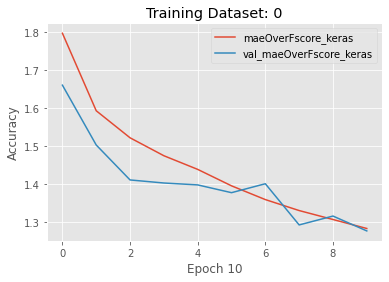

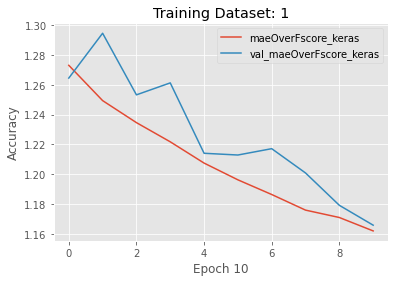

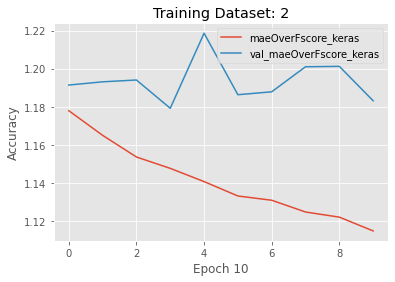

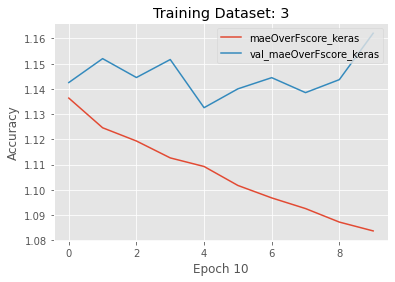

In [13]:
for dataset in range(4):
    #plot_loss(model_history[dataset], 10 , f'Training Dataset: {dataset}')
    plot_acc(model_history[dataset], 10 , f'Training Dataset: {dataset}')

## 콜백 추가

In [0]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle = True)
model_history = []
fold_number = 0

for train_index, test_index in kf.split(train):
    print(f'\nFold {fold_number}')
    fold_number = fold_number + 1
    
    def trainGenerator():
        for file in train[train_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:10]
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)
    train_dataset = tf.data.Dataset.from_generator(trainGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,10]),
                                                    tf.TensorShape([40,40,1])))
    train_dataset = train_dataset.batch(32).prefetch(1) # batch size: 512 -> 32

    def testGenerator():
        for file in train[test_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:10]
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)
    test_dataset = tf.data.Dataset.from_generator(testGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,10]),
                                                    tf.TensorShape([40,40,1])))
    test_size = len(test_index)
    test_dataset = test_dataset.batch(32).prefetch(1) # batch size: test_size -> 32

    callbacks_list = [
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    patience=3,
                    factor=0.8
                ),

                tf.keras.callbacks.ModelCheckpoint(
                    filepath = '/content/drive/My Drive/2020 Kaggle Study/model/model_new_'+str(fold_number)+'.h5',
                    monitor='val_score',
                    save_best_only=True
                )
            ]

    history = model.fit(train_dataset, epochs = 10, verbose=1, validation_data = test_dataset, callbacks=callbacks_list)

    model_history.append(history)
    #del data
    del train_dataset
    del test_dataset
    gc.collect()


Fold 0
Epoch 1/10
   1228/Unknown - 356s 290ms/step - loss: 0.1590 - maeOverFscore_keras: 1.8063 - fscore_keras: 0.6529WARNING:tensorflow:Can save best model only with val_score available, skipping.
1228/1228 [==============================] - 392s 319ms/step - loss: 0.1590 - maeOverFscore_keras: 1.8063 - fscore_keras: 0.6529 - val_loss: 0.1429 - val_maeOverFscore_keras: 1.5081 - val_fscore_keras: 0.7068 - lr: 0.0010
Epoch 2/10
1228/1228 [==============================] - 368s 300ms/step - loss: 0.1450 - maeOverFscore_keras: 1.5945 - fscore_keras: 0.6807 - val_loss: 0.1380 - val_maeOverFscore_keras: 1.4610 - val_fscore_keras: 0.7092 - lr: 0.0010
Epoch 3/10
1228/1228 [==============================] - 367s 299ms/step - loss: 0.1417 - maeOverFscore_keras: 1.5241 - fscore_keras: 0.6949 - val_loss: 0.1458 - val_maeOverFscore_keras: 1.4576 - val_fscore_keras: 0.7136 - lr: 0.0010
Epoch 4/10
1228/1228 [==============================] - 367s 299ms/step - loss: 0.1394 - maeOverFscore_keras: 1.

## submission 만들기

In [0]:
del train

In [0]:
test_submit = np.load('/content/drive/My Drive/2020 Kaggle Study/data/test.npy')

# land_type, latitude, longitude copy
land_type_data = test_submit[:,:,:,9].copy()
gmi_lat_lon = test_submit[:,:,:,10:12].copy()
dpr_lat_lon = test_submit[:,:,:,12:14].copy()

dummy = np.random.rand(test_submit.shape[0], 40, 40, 1)
test_submit = np.concatenate((test_submit, dummy), axis=3)
test_shape = test_submit.shape
test_submit = scaler.transform(test_submit.reshape(-1, 15))
test_submit = test_submit.reshape(test_shape)

land_type_data = np.where(land_type_data//100 == 2, 0.8,
                          np.where(land_type_data//100 == 3, 0.1,
                                   land_type_data//100))
test_submit[:,:,:,9] = land_type_data
test_submit[:,:,:,10:12] = gmi_lat_lon
test_submit[:,:,:,12:14] = dpr_lat_lon

In [0]:
# 0~8번 채널, landtype 이용해서 타겟 예측
# 위도, 경도 남겨 놓음
pred = model.predict(test_submit[:,:,:,:10])
test_submit[:,:,:,-1] = pred.reshape(-1, 40, 40)

In [26]:
test_submit.shape

(2416, 40, 40, 15)

## GMI precipatation -> DPR precipatation

In [0]:
dr = [(-1, -1), (-1, 0), (-1, 1),
      (0, -1), (0, 0), (0, 1),
      (1, -1), (1, 0), (1, 1)]

# p1, p2: shape=(-1, 2).
def get_dist(p1, p2):
    x1 = np.deg2rad(p1[:,0])
    y1 = np.deg2rad(p1[:,1])
    x2 = np.deg2rad(p2[:,0])
    y2 = np.deg2rad(p2[:,1])
    dlon = x2 - x1
    dlat = y2 - y1
    a = np.sin(dlat/2)**2 + np.cos(y1) * np.cos(y2) * np.sin(dlon/2)**2 
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))    
    return 6373.0 * c  # km, shape=(-1).

# ori_ll에서의 value 값을 tgt_ll에 대한 값으로 바꾼다.
# value: (40, 40, -1)
# ori_ll, tgt_ll: (40, 40, 2)
# ori_ll: value에 대응되는 원래 latitude, longitude.
# tgt_ll: 변환되는 값에 대응되는 latitude, longitude.
def compen_ll(value, ori_ll, tgt_ll):
    ret = np.empty_like(value)

    n = value.shape[0]
    m = value.shape[1]

    for i in range(n):
        for j in range(m):
            nears = []  # (row, col, value)
            for k in range(9):
                ii = i + dr[k][0]
                jj = j + dr[k][1]
                if ii >= 0 and ii < n and jj >= 0 and jj < m:
                    nears.append((ori_ll[ii, jj][0], ori_ll[ii, jj][1],
                                  tgt_ll[i, j][0], tgt_ll[i, j][1],
                                  value[ii, jj]))

            nears = np.array(nears)  # shape=(-1, 5)
            dists = get_dist(nears[:, 0:2], nears[:, 2:4]).reshape(-1, 1)
            values = nears[:, 4].reshape(-1, 1)
            nears = np.concatenate((dists, values), 1)
            nears = nears[np.argsort(nears[:, 0])]  # sort by dist

            weights = 1 / (nears[:, 0] ** 2 + sys.float_info.epsilon)
            weighted_sum = (weights * nears[:, 1]).sum()
            ret[i, j] = weighted_sum / weights.sum()
    return ret

In [28]:
import sys
from multiprocessing import Process, Manager

n_procs = 4
procs = []
manager = Manager()
dpr_preci = manager.list([None] * n_procs)

# split train into n_procs arrays
n_imgs = test_submit.shape[0]
splitted = np.split(test_submit, np.arange((n_imgs + n_procs - 1) // n_procs,
                                     n_imgs, n_imgs // n_procs))

def proc_func(proc_id):
    part = splitted[proc_id]
    arr = np.empty_like(part[:, :, :, 14])  # shape=(-1, 40, 40)
    for i in range(part.shape[0]):
        arr[i, :, :] = compen_ll(part[i, :, :, 14],
                                 part[i, :, :, 10:12],
                                 part[i, :, :, 12:14])
        if (i + 1) % 200 == 0:
            print(proc_id, i + 1)
    dpr_preci[proc_id] = arr

for proc_id in range(n_procs):
    proc = Process(target=proc_func, args=(proc_id, ))
    proc.start()
    procs.append(proc)

for proc in procs:
    proc.join()

dpr_preci = np.concatenate(dpr_preci)
dpr_preci = dpr_preci.reshape(-1, 40, 40, 1)
# dpr_preci = dpr_preci.astype(np.float32)

3 200
0 200
2 200
1 200
3 400
2 400
1 400
0 400
3 600
1 600
2 600
0 600


## submission 만들기

In [0]:
submission.iloc[:,1:] = dpr_preci.reshape(-1, 1600)

In [0]:
submission.to_csv('Dacon_new_model.csv', index = False)

In [0]:
# 제출파일 구글 드라이브에 올리기
!cp Dacon_new_model.csv '/content/drive/My Drive/2020 Kaggle Study/submission'